In [1]:
def is_jupyter():
    try:
        __IPYTHON__
        return True
    except NameError:
        return False

# Pip Install

In [2]:
if is_jupyter():
    !pip install boto3 astropy sfdmap progressbar2 GPUtil

# Initialization

In [3]:
# Make sure a GPU is available
import GPUtil
print('GPUs:\n{0}'.format('\n'.join(['('+str(i+1)+')\t'+gpu.name for i,gpu in enumerate(GPUtil.getGPUs())])))
import tensorflow as tf
assert tf.config.list_physical_devices('GPU')[0].device_type == 'GPU', 'GPU is not available!'

GPUs:
(1)	NVIDIA GeForce GTX 1080 Ti


2023-01-14 21:43:04.686478: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 21:43:04.929847: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-14 21:43:05.764352: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-14 21:43:05.764425: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: 

In [4]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
import boto3
from matplotlib import pyplot as plt
import time

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'thesis2')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'thesis2')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_models_dir_path = os.path.join(s3_work_dir_path , 'models')
s3_final_table_csv_path = os.path.join(s3_data_dir_path, 'SDSS_DR16_all.csv')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig
from s3 import log_s3, s3_save_TF_model
from NN import DistanceLayer, SiameseModel, DistillationDataGenerator

# Prepare Data

In [5]:
model_name = 'NN'

In [6]:
# prepare model paths
s3_model_dir_path = os.path.join(s3_models_dir_path, model_name)
s3_model_train_dir_path = os.path.join(s3_model_dir_path, 'train')
s3_model_test_dir_path = os.path.join(s3_model_dir_path, 'test')
# prepare data paths
s3_data_model_dir_path = os.path.join(s3_data_dir_path, model_name)
s3_data_train_dir_path = os.path.join(s3_data_model_dir_path, 'train')
s3_data_test_dir_path = os.path.join(s3_data_model_dir_path, 'test')

In [7]:
# load data
dist_mat_path = os.path.join(s3_models_dir_path, 'SmallRF', 'train', 'dist_mat.npy')
dist_mat = from_s3_npy(s3_client, bucket_name, dist_mat_path)
X_train = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_train_dir_path, 'spec.npy'))
X_test = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_test_dir_path, 'spec.npy'))

loading from uri: s3://tau-astro/almogh/thesis2/models/SmallRF/train/dist_mat.npy
loading from uri: s3://tau-astro/almogh/thesis2/data/NN/train/spec.npy
loading from uri: s3://tau-astro/almogh/thesis2/data/NN/test/spec.npy


In [8]:
# gs_SmallRF_train = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_dir_path, 'SmallRF', 'train', 'gs.pkl')) # <- This is equal to g_NN
gs = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_model_dir_path, 'gs.pkl'))
gs_train = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_train_dir_path, 'gs.pkl'))
gs_test = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_test_dir_path, 'gs.pkl'))

loading from uri: s3://tau-astro/almogh/thesis2/data/NN/gs.pkl
loading from uri: s3://tau-astro/almogh/thesis2/data/NN/train/gs.pkl
loading from uri: s3://tau-astro/almogh/thesis2/data/NN/test/gs.pkl


In [9]:
I_train = np.array([np.where(gs.index == i)[0][0] for i in gs_train.index])
I_test = np.array([np.where(gs.index == i)[0][0] for i in gs_test.index])

In [10]:
dist_mat_train = dist_mat[I_train,:][:,I_train]
dist_mat_test = dist_mat[I_test,:][:,I_test]

In [11]:
if is_jupyter():
    X_train = X_train[:100,:]
    X_test = X_test[:10,:]
    dist_mat_train = dist_mat_train[:100,:][:,:100]
    dist_mat_test = dist_mat_test[:10,:][:,:10]

# Creating the model

In [12]:
N_features = X_train.shape[1]

In [13]:
from tensorflow.keras import applications
from tensorflow.keras import activations
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras import utils
from tensorflow.keras import initializers

tf.random.set_seed(seed)

## Embedding Network

In [14]:
hidden_size = 512
encoding_size = 128

# input layer
x_in = layers.Input(shape=(N_features, 1))

# adding the network layers
x = x_in
x = layers.Conv1D(64, 31, activation=None, padding='same', kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.AveragePooling1D( 2, padding='same')(x)
x = layers.Conv1D(32, 31, activation=None, padding='same', kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.AveragePooling1D( 2, padding='same')(x)
x = layers.Conv1D(16, 31, activation=None, padding='same', kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.AveragePooling1D( 2, padding='same')(x)
x = layers.Conv1D(8, 31, activation=None, padding='same', kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.AveragePooling1D( 2, padding='same')(x)
x = layers.Conv1D(4, 31, activation=None, padding='same', kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.AveragePooling1D( 2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(hidden_size, kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.Dense(encoding_size, kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.tanh(x)
x_out = x

# creating the model
encoding = Model(x_in, x_out)
encoding.summary()

2023-01-14 21:43:17.766459: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-14 21:43:18.693717: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10407 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:60:00.0, compute capability: 6.1


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8400, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 8400, 64)          2048      
                                                                 
 batch_normalization (BatchN  (None, 8400, 64)         256       
 ormalization)                                                   
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 8400, 64)          0         
                                                                 
 average_pooling1d (AverageP  (None, 4200, 64)         0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 4200, 32)          63520 

## Siamese Network

In [15]:
first_input = layers.Input(name="first_input", shape=(N_features))
second_input = layers.Input(name="second_input", shape=(N_features))

first_encoding = encoding(first_input)
second_encoding = encoding(second_input)

distance = tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(first_encoding - second_encoding), -1),1e-9))

siamese_network = Model(
    inputs=[first_input, second_input], outputs=distance
)
siamese_network.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 first_input (InputLayer)       [(None, 8400)]       0           []                               
                                                                                                  
 second_input (InputLayer)      [(None, 8400)]       0           []                               
                                                                                                  
 model (Functional)             (None, 128)          694284      ['first_input[0][0]',            
                                                                  'second_input[0][0]']           
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 128)          0           ['model[0][0]',            

## Siamese Model

In [16]:
siamese_model = SiameseModel(siamese_network, dist_loss='L1')
siamese_model.compile(optimizer=optimizers.Adam(0.001))

# Train Model

In [17]:
train_gen = DistillationDataGenerator(X_train, dist_mat_train, batch_size=128, shuffle=True, seed=seed, snr_range_db=[6,40], full_epoch=False, norm=True)
test_gen = DistillationDataGenerator(X_test, dist_mat_test, batch_size=128, shuffle=True, seed=seed, snr_range_db=[6,40], full_epoch=False, norm=True)

In [18]:
def plot_loss(fig, ax, e, loss_history, val_loss_history):
    if ax.lines:
        for i,line in enumerate(ax.lines):
            line.set_xdata(e)
            if (i==1):
                line.set_ydata(loss_history)
            else:
                line.set_ydata(val_loss_history)
    else:
        ax.plot(e, loss_history, label='training')
        ax.plot(e, val_loss_history, label='test')
        ax.legend()
    fig.canvas.draw()

Training for 50 full epochs, and stopping for saving every 5 full epochs, for a total of 10 stages.
-------------------------------------
epochs 1-5:
-------------------------------------


2023-01-14 21:43:20.719240: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


Epoch 1/5
1/1 [==============================] - 4s 4s/step - loss: 0.1629 - val_loss: 0.2429
Epoch 2/5
1/1 [==============================] - 1s 535ms/step - loss: 0.1246 - val_loss: 0.1531
Epoch 3/5
1/1 [==============================] - 1s 544ms/step - loss: 0.1077 - val_loss: 0.1119
Epoch 4/5
1/1 [==============================] - 1s 539ms/step - loss: 0.0718 - val_loss: 0.0705
Epoch 5/5
1/1 [==============================] - 1s 525ms/step - loss: 0.0401 - val_loss: 0.0986


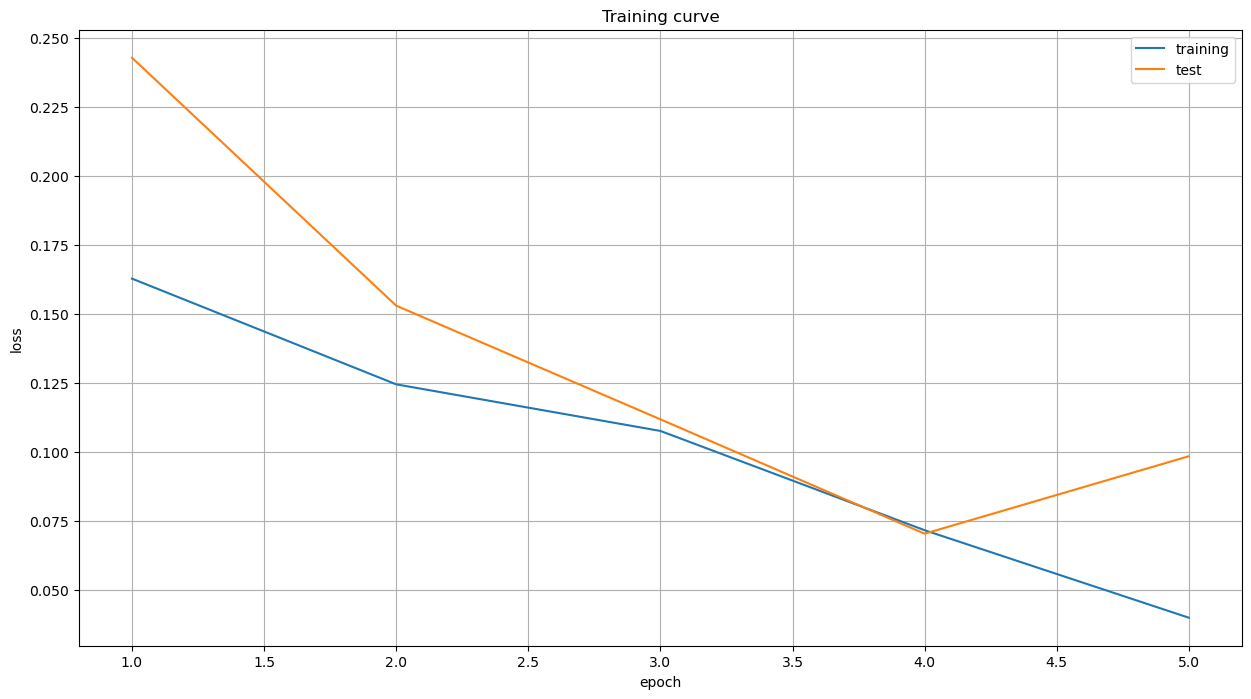

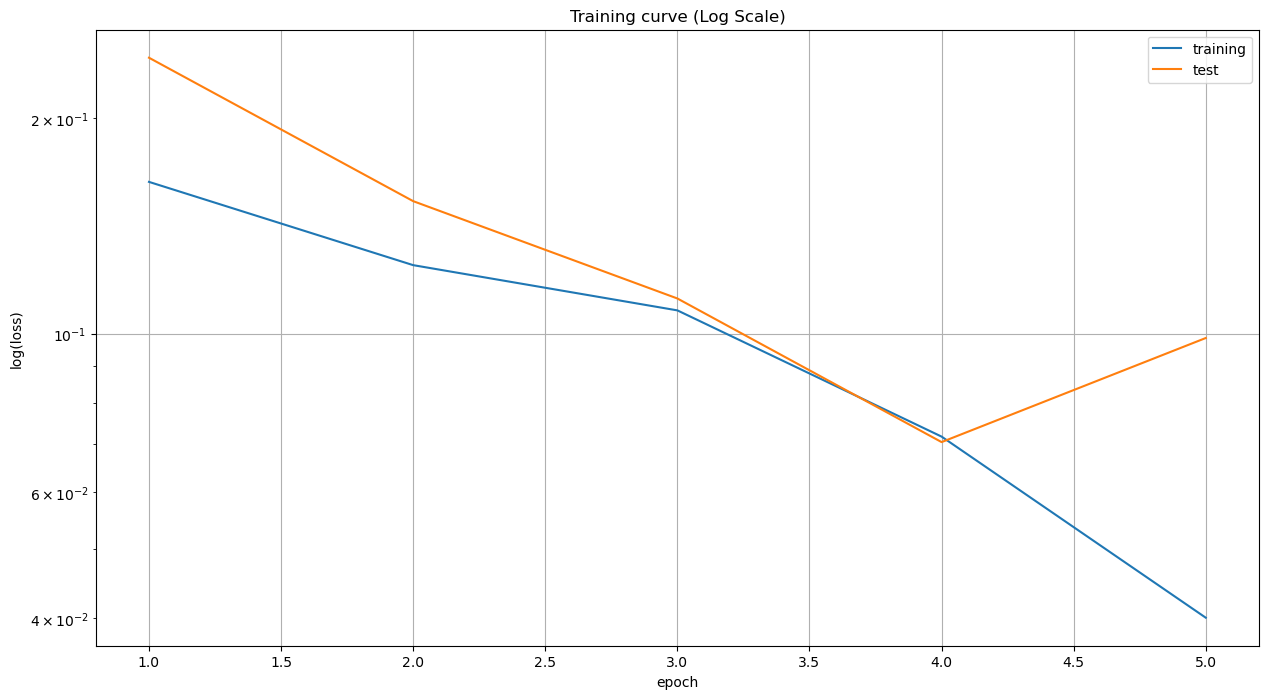

TOTAL TIME = 0.003 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmpjxumrqsr/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpjxumrqsr/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/model
-------------------------------------
epochs 6-10:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 670ms/step - loss: 0.0416 - val_loss: 0.1064
Epoch 2/5
1/1 [==============================] - 1s 534ms/step - loss: 0.0531 - val_loss: 0.0628
Epoch 3/5
1/1 [==============================] - 1s 541ms/step - loss: 0.0370 - val_loss: 0.1434
Epoch 4/5
1/1 [==============================] - 1s 533ms/step - loss: 0.0931 - val_loss: 0.0640
Epoch 5/5
1/1 [==============================] - 1s 533ms/step - loss: 0.0390 - val_loss: 0.0829


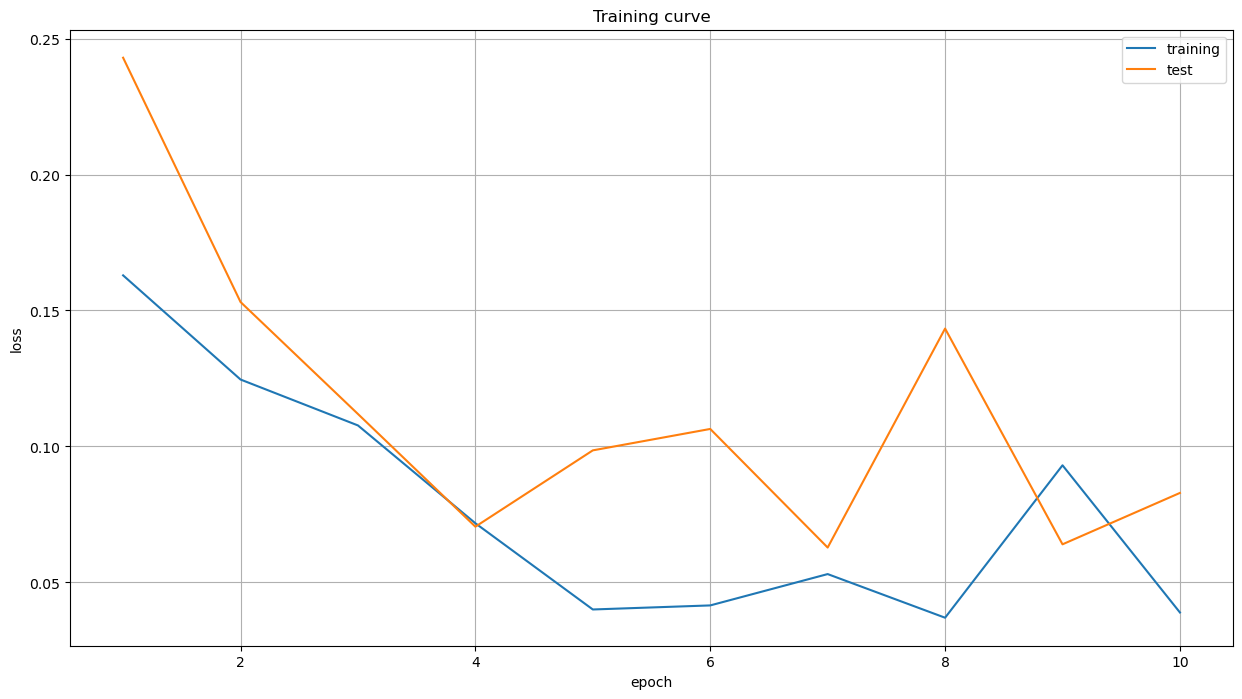

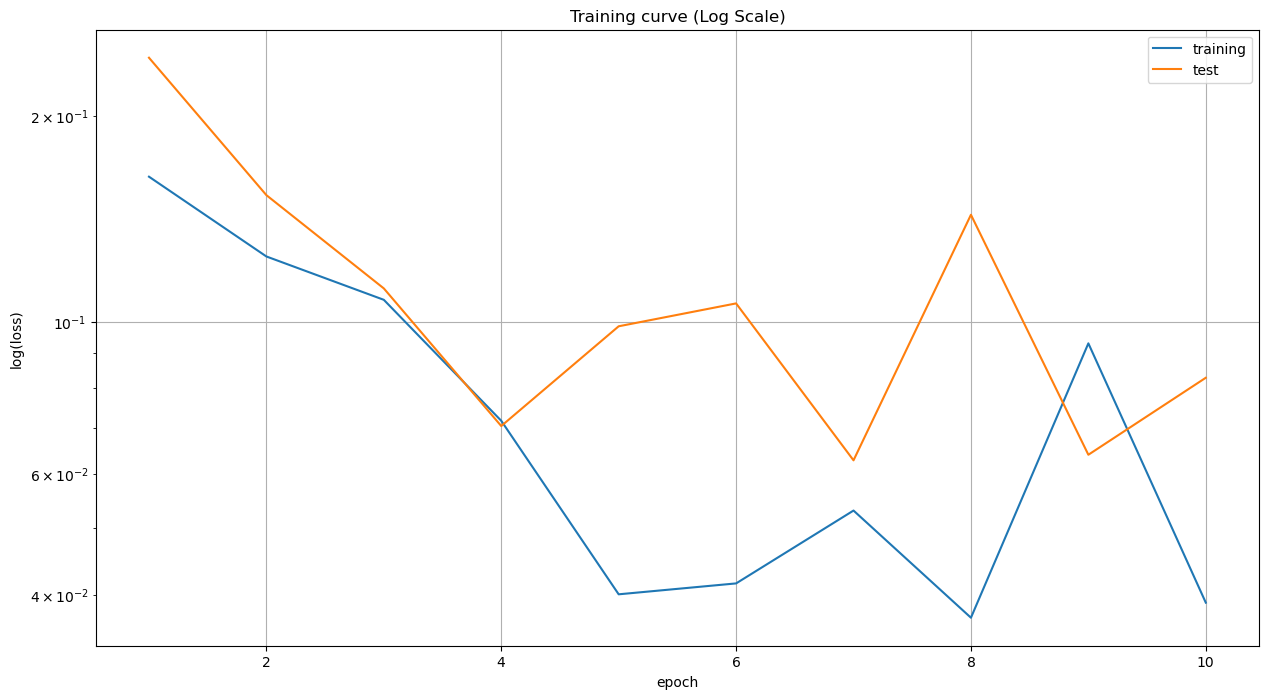

TOTAL TIME = 0.008 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_10_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_10_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_10_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_10_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_10_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmpxxikzx4t/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpxxikzx4t/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_10_epochs/model
-------------------------------------
epochs 11-15:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 707ms/step - loss: 0.0545 - val_loss: 0.0906
Epoch 2/5
1/1 [==============================] - 1s 553ms/step - loss: 0.0576 - val_loss: 0.0819
Epoch 3/5
1/1 [==============================] - 1s 557ms/step - loss: 0.0383 - val_loss: 0.1187
Epoch 4/5
1/1 [==============================] - 1s 554ms/step - loss: 0.0586 - val_loss: 0.0990
Epoch 5/5
1/1 [==============================] - 1s 530ms/step - loss: 0.0421 - val_loss: 0.1043


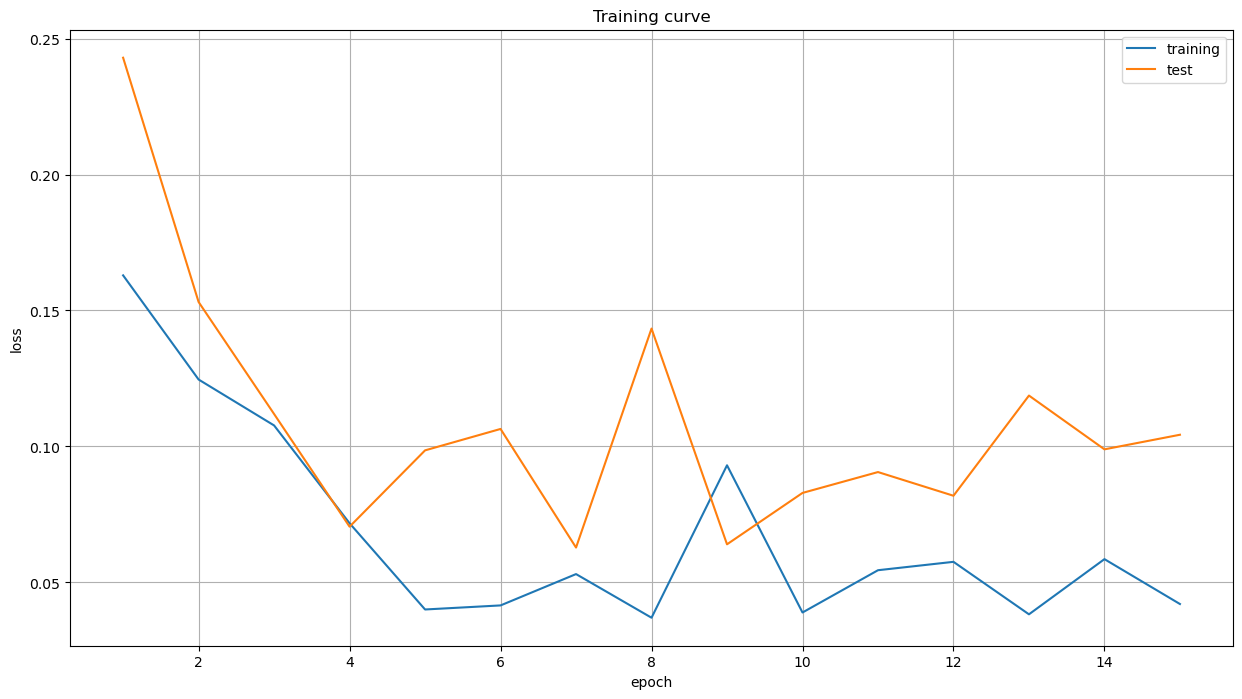

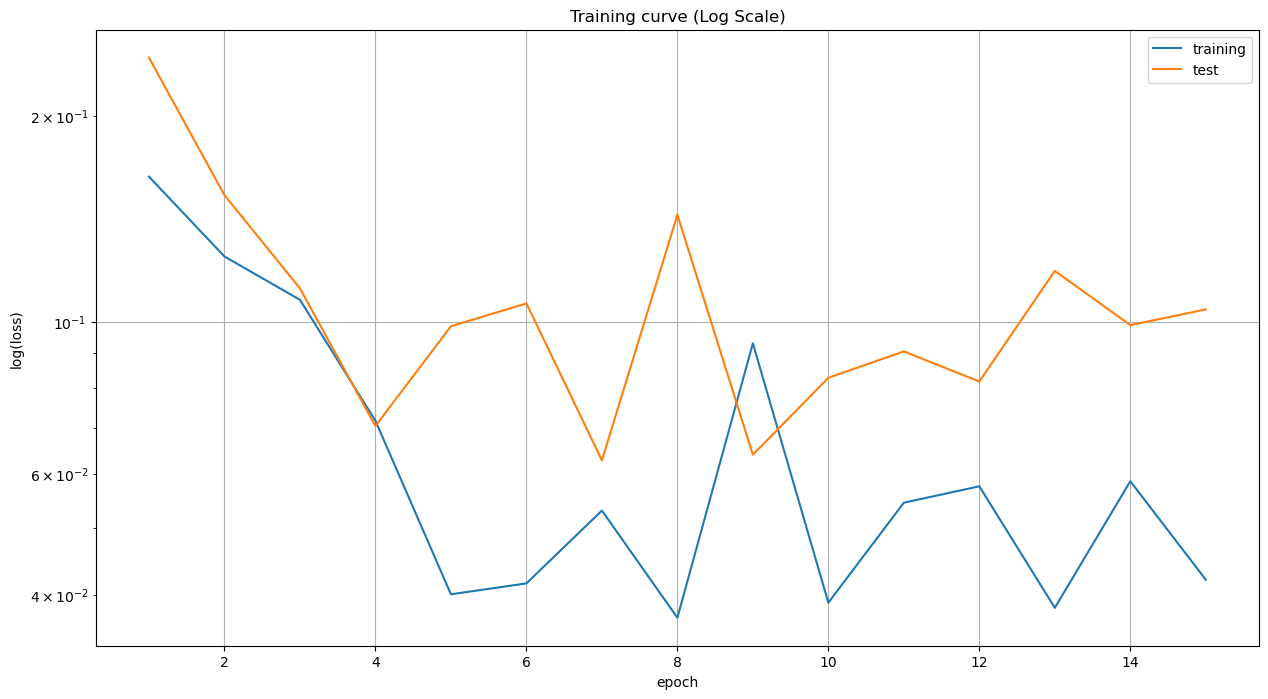

TOTAL TIME = 0.014 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_15_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_15_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_15_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_15_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_15_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmpiui1rvo0/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpiui1rvo0/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_15_epochs/model
-------------------------------------
epochs 16-20:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 672ms/step - loss: 0.0404 - val_loss: 0.1029
Epoch 2/5
1/1 [==============================] - 1s 544ms/step - loss: 0.0399 - val_loss: 0.0937
Epoch 3/5
1/1 [==============================] - 1s 546ms/step - loss: 0.0333 - val_loss: 0.0849
Epoch 4/5
1/1 [==============================] - 1s 545ms/step - loss: 0.0388 - val_loss: 0.0926
Epoch 5/5
1/1 [==============================] - 1s 520ms/step - loss: 0.0315 - val_loss: 0.0935


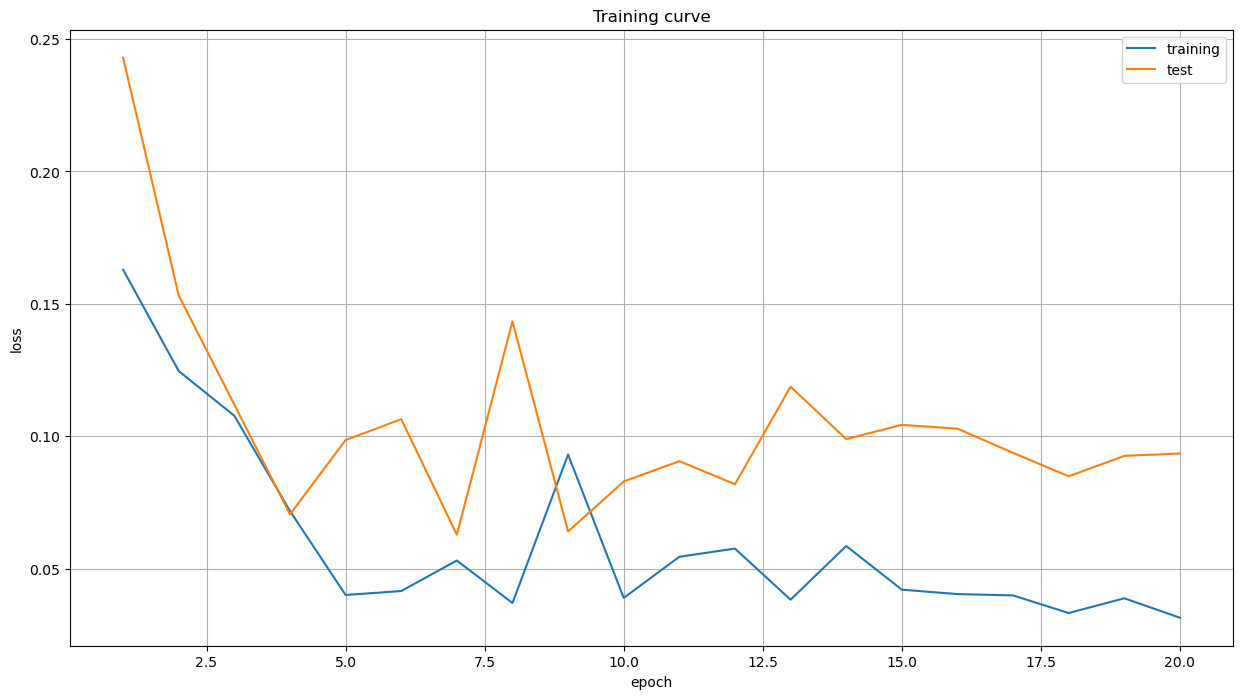

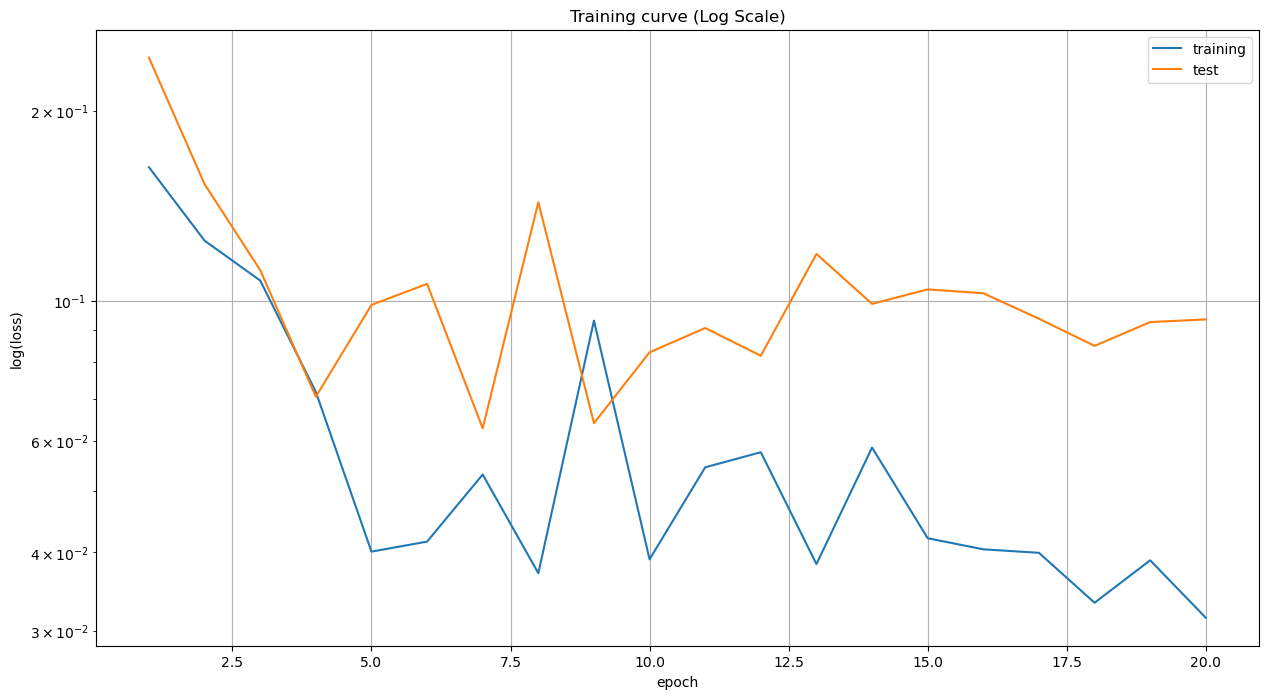

TOTAL TIME = 0.019 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_20_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_20_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_20_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_20_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_20_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmp2skiu8fp/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp2skiu8fp/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_20_epochs/model
-------------------------------------
epochs 21-25:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 712ms/step - loss: 0.0305 - val_loss: 0.0905
Epoch 2/5
1/1 [==============================] - 1s 566ms/step - loss: 0.0291 - val_loss: 0.0755
Epoch 3/5
1/1 [==============================] - 1s 558ms/step - loss: 0.0302 - val_loss: 0.0768
Epoch 4/5
1/1 [==============================] - 1s 565ms/step - loss: 0.0302 - val_loss: 0.0944
Epoch 5/5
1/1 [==============================] - 1s 563ms/step - loss: 0.0284 - val_loss: 0.0896


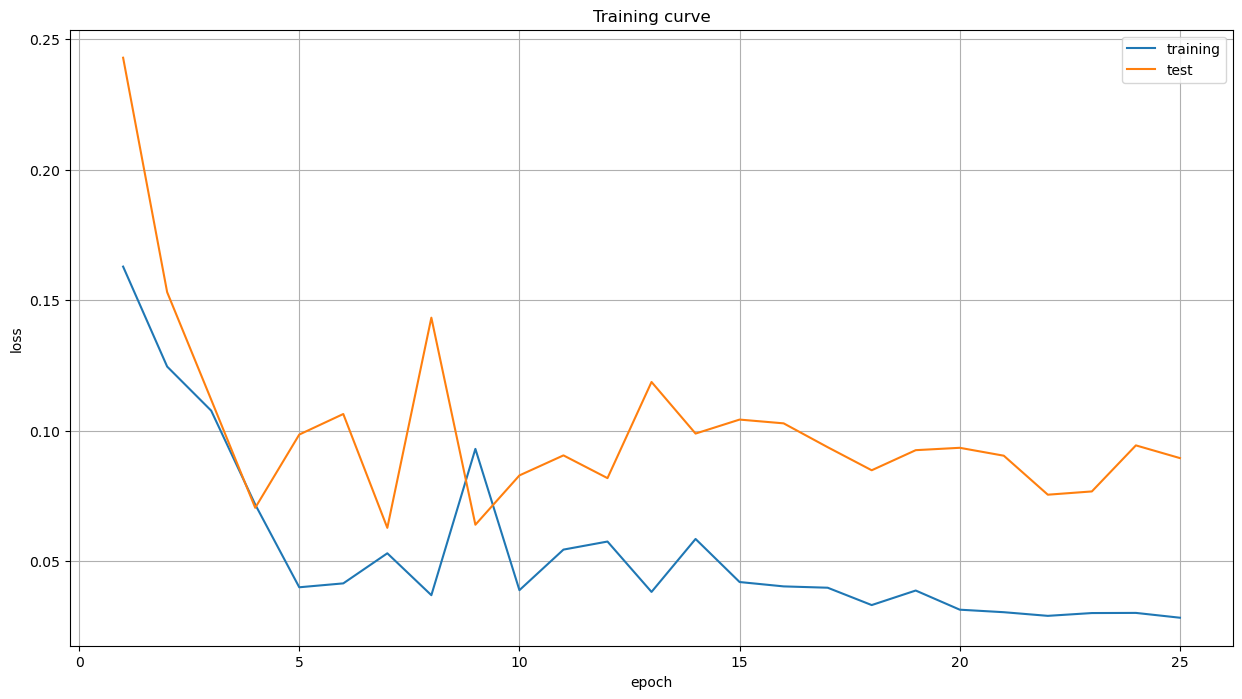

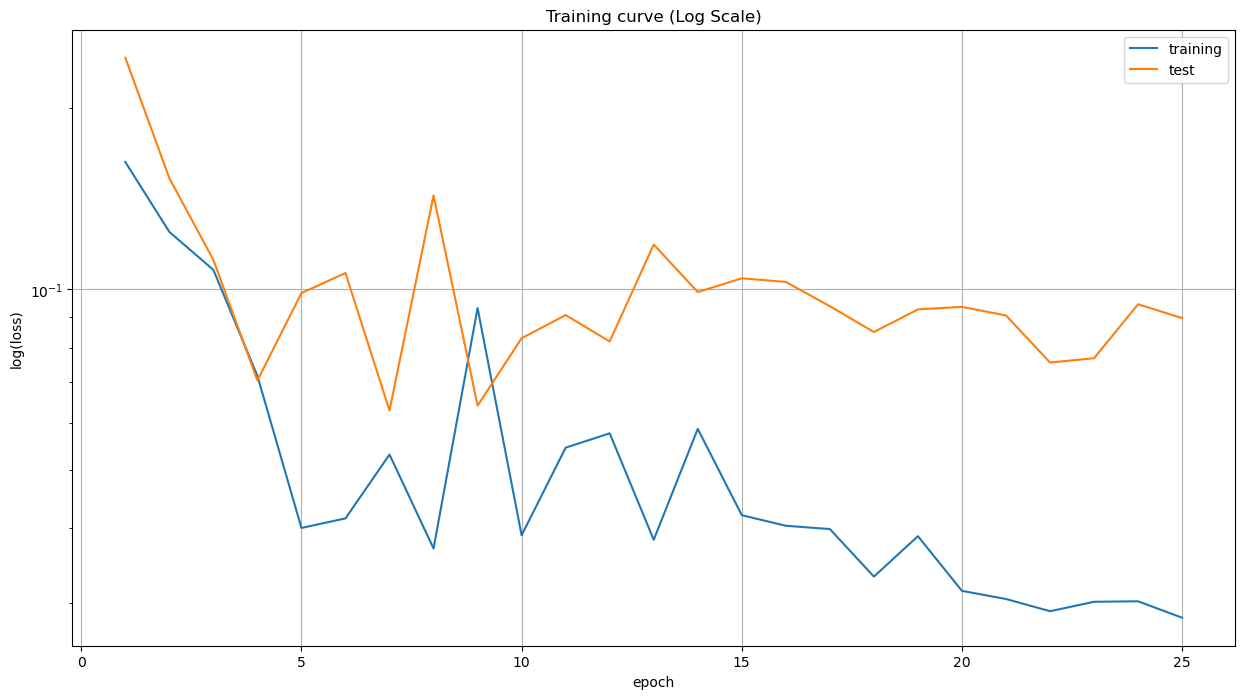

TOTAL TIME = 0.025 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_25_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_25_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_25_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_25_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_25_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmph3aupyrb/model/assets


INFO:tensorflow:Assets written to: /tmp/tmph3aupyrb/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_25_epochs/model
-------------------------------------
epochs 26-30:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 683ms/step - loss: 0.0261 - val_loss: 0.0895
Epoch 2/5
1/1 [==============================] - 1s 543ms/step - loss: 0.0303 - val_loss: 0.0701
Epoch 3/5
1/1 [==============================] - 1s 551ms/step - loss: 0.0316 - val_loss: 0.0767
Epoch 4/5
1/1 [==============================] - 1s 558ms/step - loss: 0.0297 - val_loss: 0.0921
Epoch 5/5
1/1 [==============================] - 1s 536ms/step - loss: 0.0413 - val_loss: 0.0639


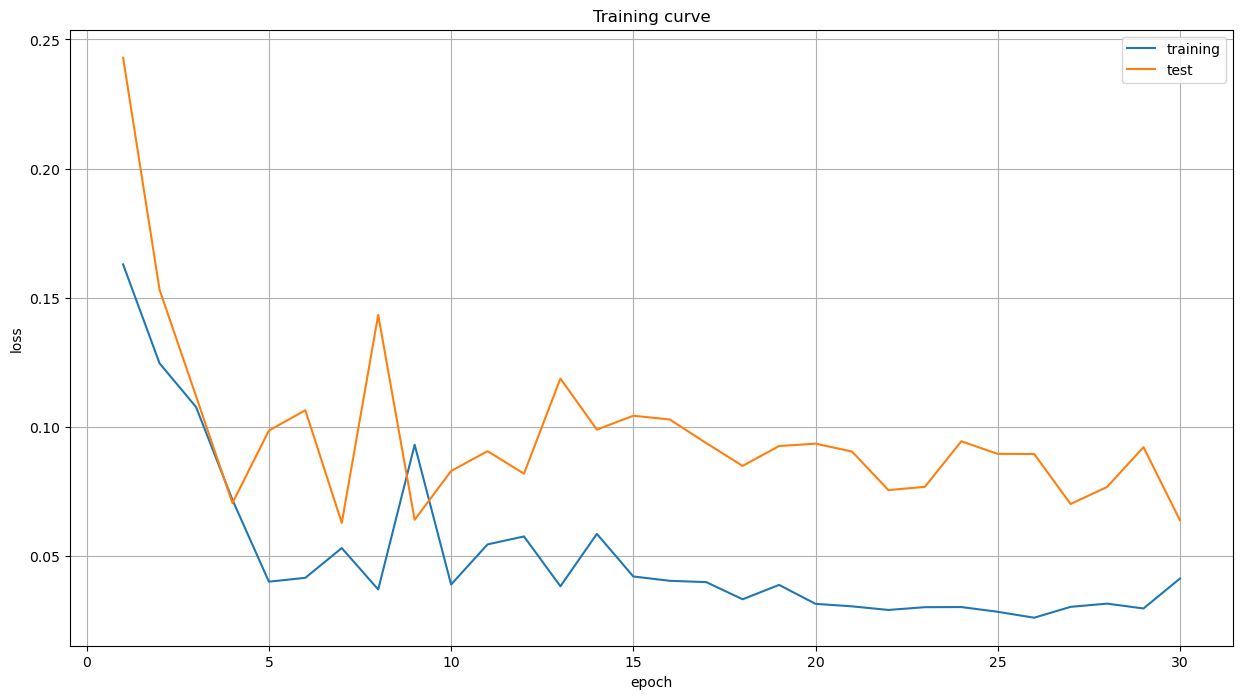

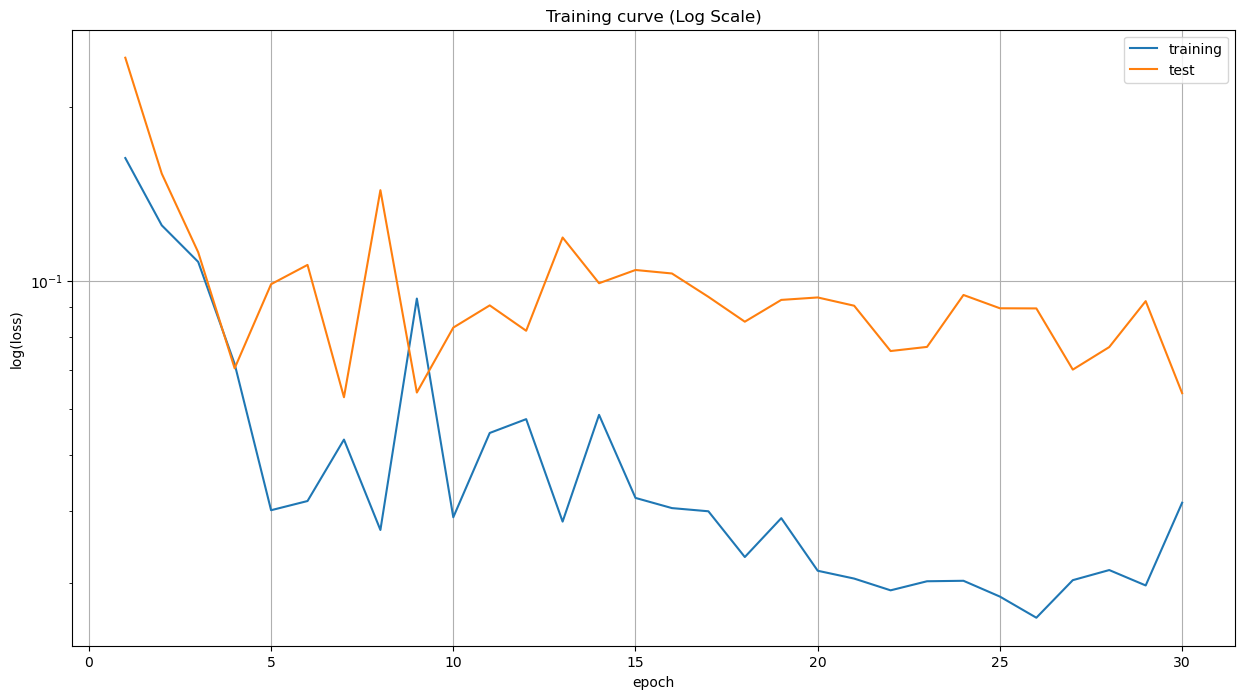

TOTAL TIME = 0.030 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_30_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_30_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_30_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_30_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_30_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmpzizurz4q/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpzizurz4q/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_30_epochs/model
-------------------------------------
epochs 31-35:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 658ms/step - loss: 0.0320 - val_loss: 0.0754
Epoch 2/5
1/1 [==============================] - 1s 560ms/step - loss: 0.0322 - val_loss: 0.0998
Epoch 3/5
1/1 [==============================] - 1s 548ms/step - loss: 0.0285 - val_loss: 0.0855
Epoch 4/5
1/1 [==============================] - 1s 518ms/step - loss: 0.0413 - val_loss: 0.0881
Epoch 5/5
1/1 [==============================] - 1s 514ms/step - loss: 0.0284 - val_loss: 0.0720


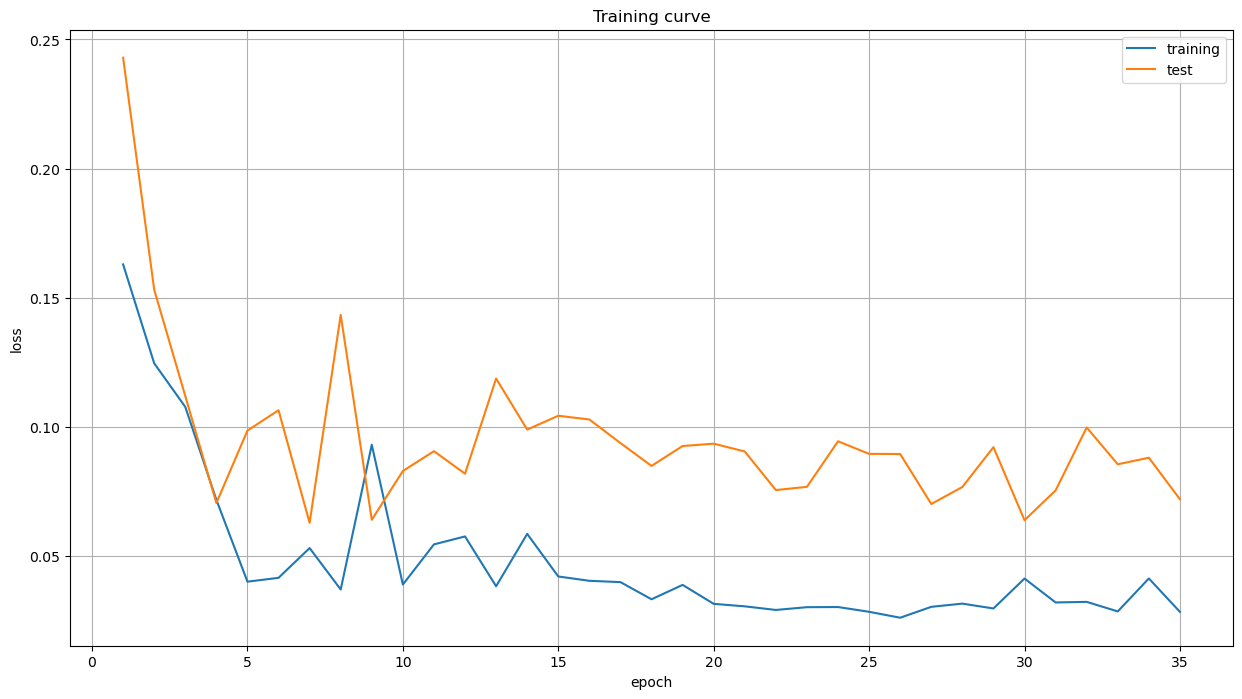

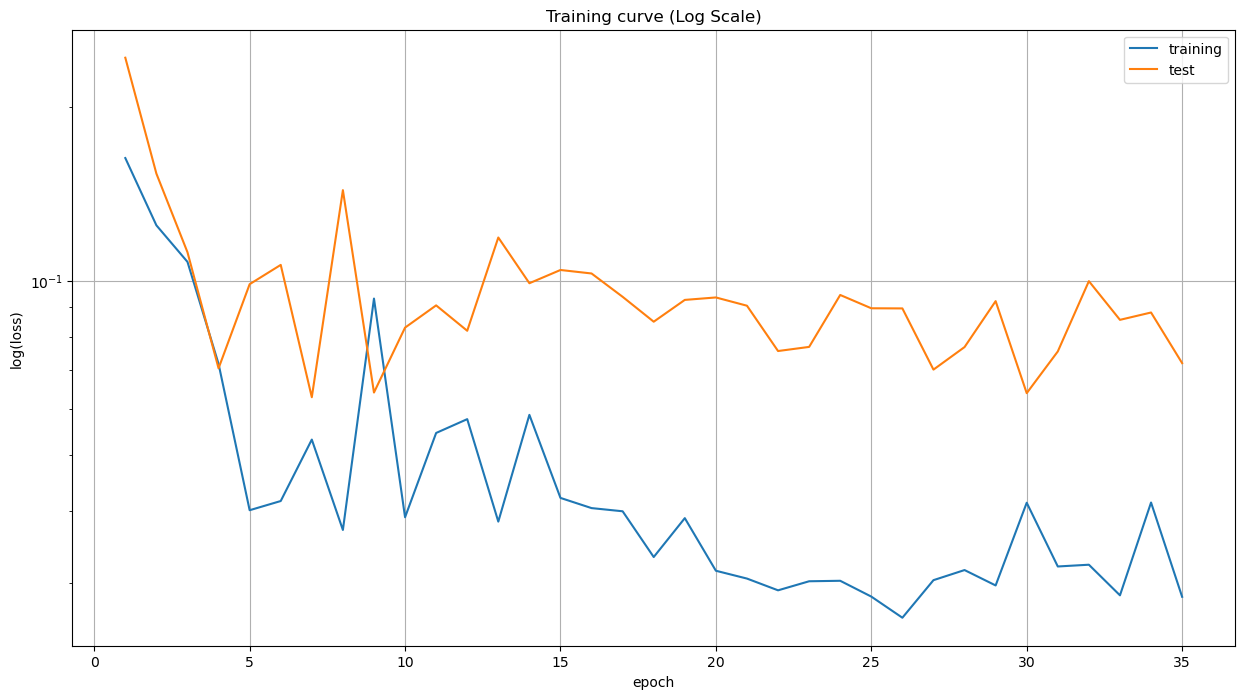

TOTAL TIME = 0.035 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_35_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_35_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_35_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_35_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_35_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmp3xs2t24p/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp3xs2t24p/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_35_epochs/model
-------------------------------------
epochs 36-40:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 714ms/step - loss: 0.0377 - val_loss: 0.0795
Epoch 2/5
1/1 [==============================] - 1s 551ms/step - loss: 0.0291 - val_loss: 0.0797
Epoch 3/5
1/1 [==============================] - 1s 544ms/step - loss: 0.0234 - val_loss: 0.0702
Epoch 4/5
1/1 [==============================] - 0s 497ms/step - loss: 0.0312 - val_loss: 0.0971
Epoch 5/5
1/1 [==============================] - 1s 539ms/step - loss: 0.0291 - val_loss: 0.0885


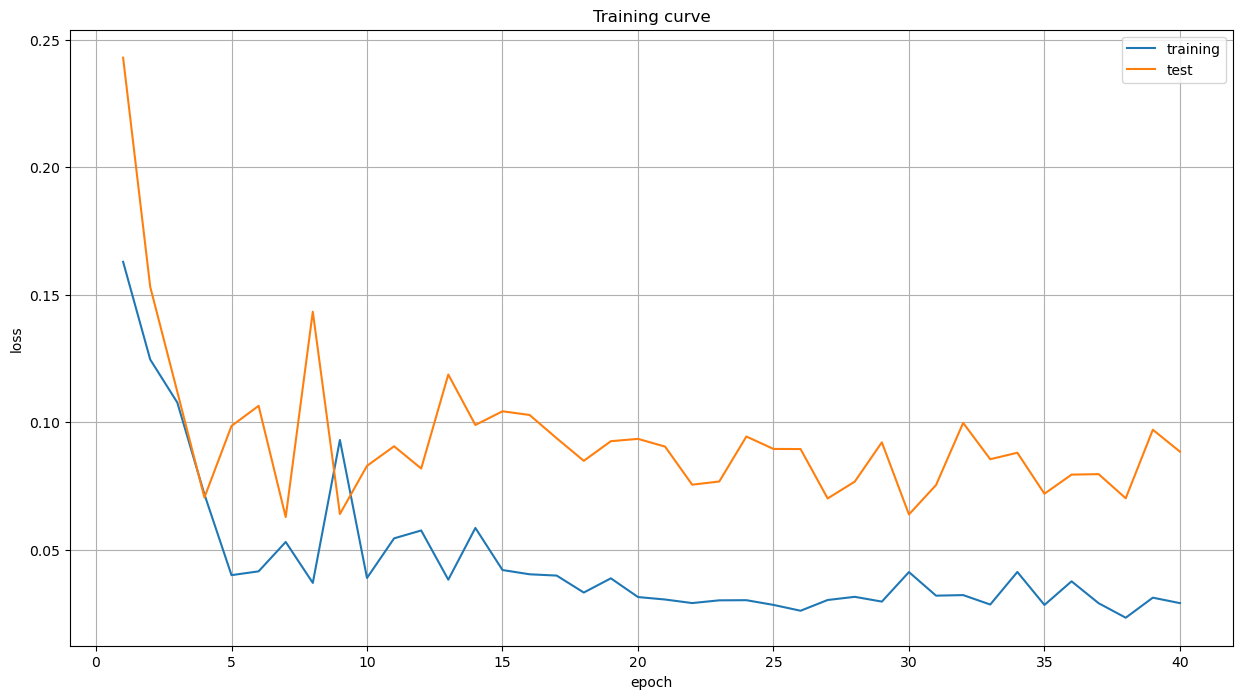

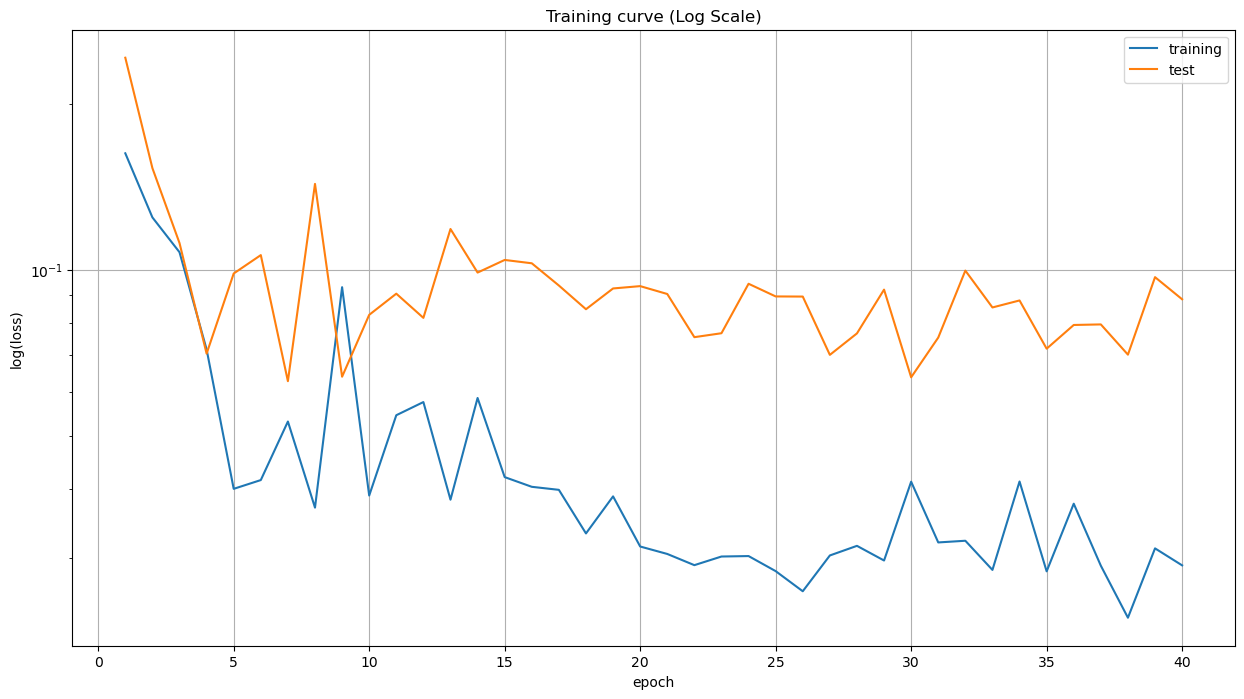

TOTAL TIME = 0.041 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_40_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_40_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_40_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_40_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_40_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmpd5s0gtb_/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpd5s0gtb_/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_40_epochs/model
-------------------------------------
epochs 41-45:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 684ms/step - loss: 0.0322 - val_loss: 0.0826
Epoch 2/5
1/1 [==============================] - 1s 507ms/step - loss: 0.0271 - val_loss: 0.1158
Epoch 3/5
1/1 [==============================] - 1s 532ms/step - loss: 0.0272 - val_loss: 0.0881
Epoch 4/5
1/1 [==============================] - 1s 522ms/step - loss: 0.0282 - val_loss: 0.1044
Epoch 5/5
1/1 [==============================] - 1s 546ms/step - loss: 0.0268 - val_loss: 0.0807


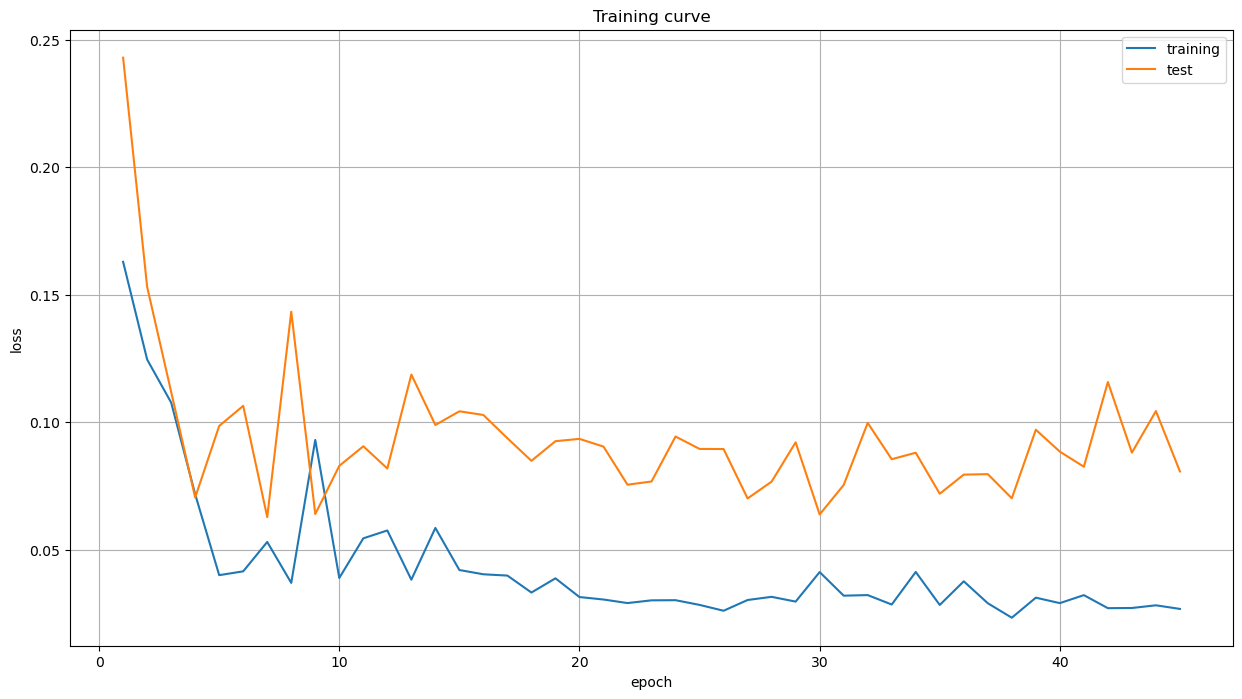

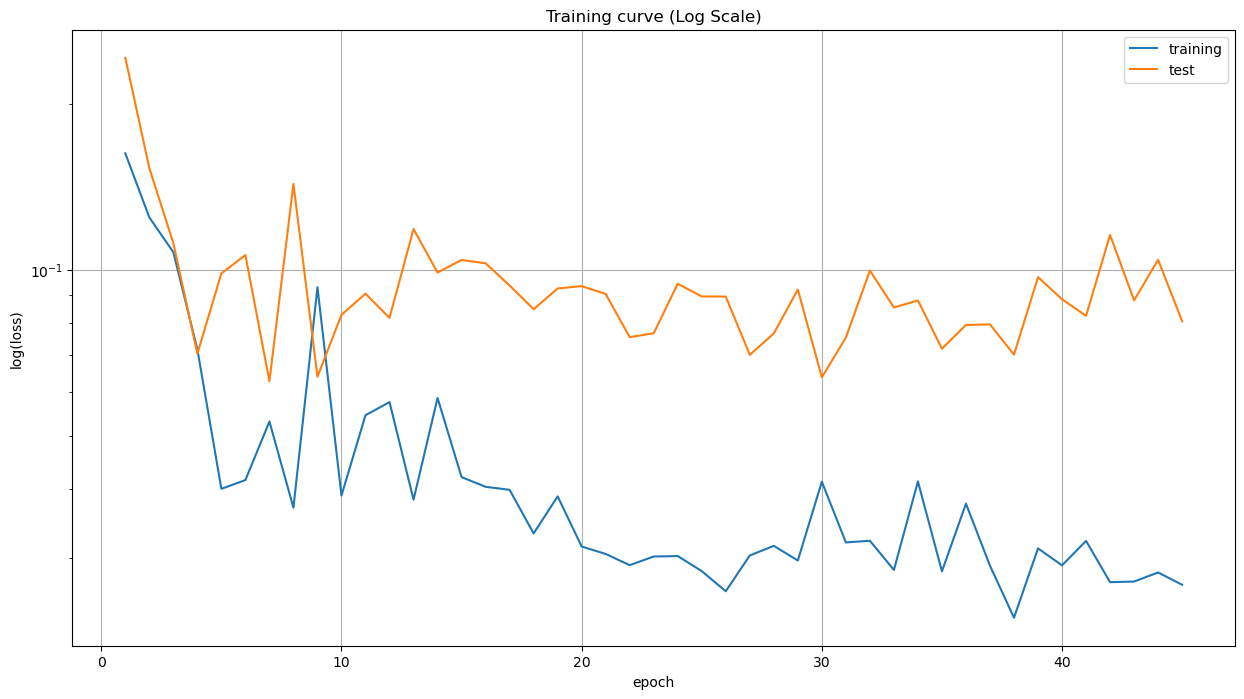

TOTAL TIME = 0.047 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_45_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_45_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_45_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_45_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_45_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmpbxdxrs5b/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpbxdxrs5b/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_45_epochs/model
-------------------------------------
epochs 46-50:
-------------------------------------
Epoch 1/5
1/1 [==============================] - 1s 728ms/step - loss: 0.0433 - val_loss: 0.0714
Epoch 2/5
1/1 [==============================] - 1s 554ms/step - loss: 0.0325 - val_loss: 0.0696
Epoch 3/5
1/1 [==============================] - 1s 527ms/step - loss: 0.0294 - val_loss: 0.1001
Epoch 4/5
1/1 [==============================] - 1s 528ms/step - loss: 0.0436 - val_loss: 0.1121
Epoch 5/5
1/1 [==============================] - 1s 514ms/step - loss: 0.0440 - val_loss: 0.1009


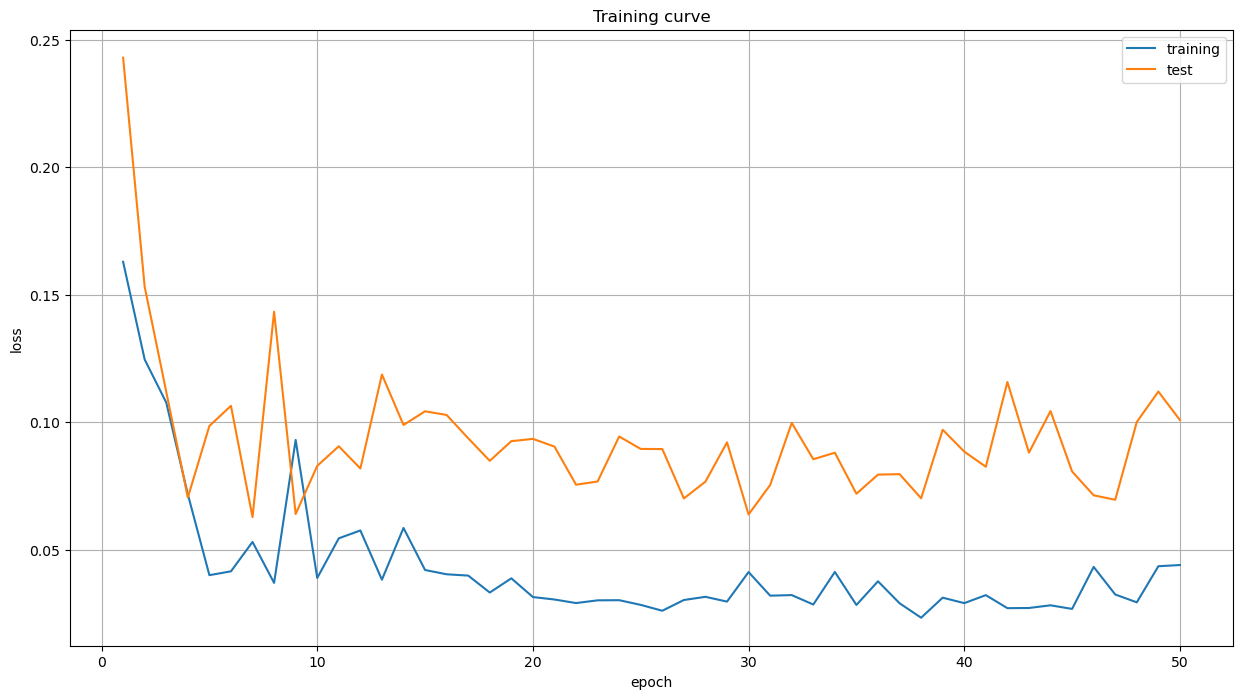

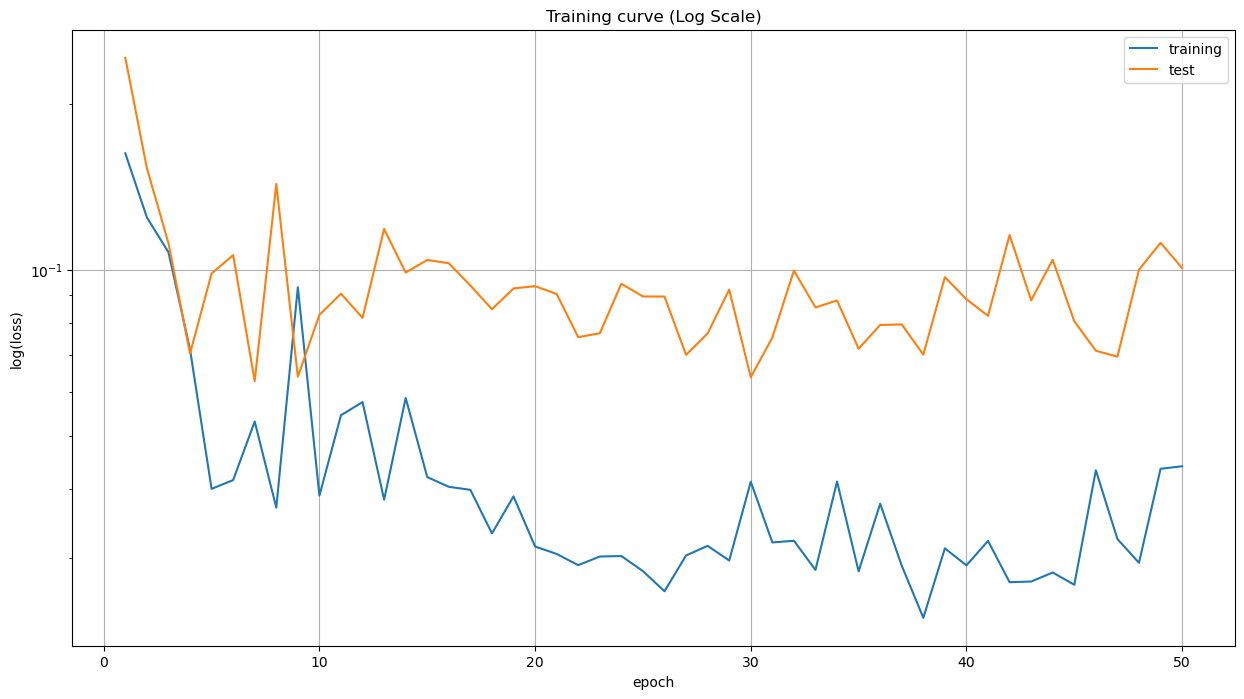

TOTAL TIME = 0.052 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_50_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_50_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_50_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_50_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_50_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmp8e_f5gqv/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp8e_f5gqv/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_50_epochs/model


In [19]:
epochs = 50
sub_epochs = 5
N_chunks = int(epochs/sub_epochs)
loss_history = []
val_loss_history = []
verbosity = 1 if is_jupyter() else 2

# training loop
print('Training for {0} full epochs, and stopping for saving every {1} full epochs, for a total of {2} stages.'.format(epochs,sub_epochs, N_chunks))
start_time = time.time()
for i_chunk in range(N_chunks):
    
    print('-------------------------------------')
    print('epochs {0}-{1}:'.format(i_chunk*sub_epochs+1, (i_chunk+1)*sub_epochs))
    print('-------------------------------------')

    # train
    try:
        # for some reason, the first call to fit will throw KeyError...
        history = siamese_model.fit(train_gen, epochs=sub_epochs, validation_data=test_gen, verbose=verbosity)
    except KeyError:
        history = siamese_model.fit(train_gen, epochs=sub_epochs, validation_data=test_gen, verbose=verbosity)
    loss_history += history.history['loss']
    val_loss_history += history.history['val_loss']
    
    # create the figures for the loss
    loss_fig, loss_ax = plt.subplots(figsize=(15,8))
    loss_ax.set_title('Training curve')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.grid()
    log_loss_fig, log_loss_ax = plt.subplots(figsize=(15,8))
    log_loss_ax.set_title('Training curve (Log Scale)')
    log_loss_ax.set_xlabel('epoch')
    log_loss_ax.set_ylabel('log(loss)')
    log_loss_ax.grid()
    log_loss_ax.set_yscale('log')
    
    # plot the loss
    curr_epochs = (i_chunk+1)*sub_epochs
    e = np.arange(curr_epochs)+1
    """
    loss_ax.plot(e, loss_history, label='training')
    loss_ax.plot(e, val_loss_history, label='test')
    loss_ax.legend()
    log_loss_ax.plot(e, loss_history, label='training')
    log_loss_ax.plot(e, val_loss_history, label='test')
    log_loss_ax.legend()
    """
    plot_loss(loss_fig, loss_ax, e, loss_history, val_loss_history)
    plot_loss(log_loss_fig, log_loss_ax, e, loss_history, val_loss_history)
    plt.show()
    time.sleep(1)
    
    end_time = time.time()
    time_str = 'TOTAL TIME = {0:.3f} hours'.format((end_time - start_time)/3600)
    print(time_str)
    
    # create a sub dir
    s3_save_NN_dir_path_sub_epoch = os.path.join(s3_model_train_dir_path, 'after_{0}_epochs'.format((i_chunk+1)*sub_epochs))
    # save the figures
    to_s3_fig(loss_fig, s3_client, bucket_name, os.path.join(s3_save_NN_dir_path_sub_epoch, 'loss.png'))
    to_s3_fig(log_loss_fig, s3_client, bucket_name, os.path.join(s3_save_NN_dir_path_sub_epoch, 'loss.png'))
    # save the losses
    to_s3_npy(np.array(loss_history), s3_client, bucket_name, os.path.join(s3_save_NN_dir_path_sub_epoch, 'loss.npy'))
    to_s3_npy(np.array(val_loss_history), s3_client, bucket_name, os.path.join(s3_save_NN_dir_path_sub_epoch, 'val_loss.npy'))
    # get model summary
    stringlist = []
    encoding.summary(print_fn=lambda x: stringlist.append(x))
    encoding_summary = "\n".join(stringlist)
    stringlist = []
    siamese_network.summary(print_fn=lambda x: stringlist.append(x))
    siamese_network_summary = "\n".join(stringlist)
    # save log
    log_s3(s3_client, bucket_name, s3_model_train_dir_path, 'NN_log.txt',
        dist_mat_path = dist_mat_path,
        s3_model_train_dir_path = s3_model_train_dir_path,
        training_duration = time_str,
        encoding_summary = encoding_summary,
        siamese_network_summary = siamese_network_summary
        )
    # save the network
    s3_model_path = os.path.join(s3_save_NN_dir_path_sub_epoch, 'model')
    s3_save_TF_model(siamese_model, s3_client, bucket_name, s3_model_path)

# Inference

In [20]:
# predict
batch_size = 128
data_gen = DistillationDataGenerator(X_train,  dist_mat_train, batch_size=128, shuffle=False, seed=seed, full_epoch=True, norm=True)
Z_NN = siamese_model.predict(data_gen, verbose=verbosity)

40/40 [==============================] - 3s 70ms/step


In [21]:
# create full distance matrix
N = int((-1+np.sqrt(1+8*len(Z_NN)))/2)
D_NN = np.zeros(shape=(N,N))
D_NN[np.triu_indices(N)] = Z_NN
D_NN = D_NN.T
D_NN[np.triu_indices(N)] = Z_NN

In [22]:
# save the distance matrix
to_s3_npy(D_NN, s3_client, bucket_name, os.path.join(s3_save_NN_dir_path_sub_epoch, 'dist_mat.npy'))

saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_50_epochs/dist_mat.npy


True